In [18]:
from fastPLNmodels.utils import build_block_Sigma, C_from_Sigma, sample_PLN, MSE
import torch
from fastPLNmodels.models import IMPS_PLN, log_likelihood, fastPLN
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from tqdm import tqdm
import torch.linalg as TLA
from torch.autograd import Variable


In [19]:
%load_ext autoreload

%autoreload 2

In [20]:
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else : 
    device = torch.device('cpu')
    
#device = torch.device('cpu') # think I can't use RTX A5000 right now, will check this later. 
torch.cuda.is_available()
# print('device ', device)

True

In [21]:
device

device(type='cuda', index=0)

### Simulation of the data 

In [85]:
d = 2
n = 200;  p = 50
q = 5

In [86]:
# 0 est pas mal 
#torch.manual_seed(0)
Sigma_sampling = 1*torch.from_numpy(build_block_Sigma(p,10))/3 #+ 0.5*torch.eye(p)
true_C = C_from_Sigma(Sigma_sampling, q)
true_C.to(device)
true_Sigma_sampling = true_C@(true_C.T)
true_beta =torch.randn((d, p), device = device)/1.5

covariates = torch.randn((n,d)).to(device)
O =  0*torch.randint(2,(n,p)).to(device)
Y, Z, _  = sample_PLN(Sigma_sampling,true_beta, O, covariates)
Y = pd.DataFrame(Y.cpu().numpy())
covariates = pd.DataFrame(covariates.cpu().numpy())
O = pd.DataFrame(O.cpu().numpy())


In [64]:
import pandas as pd

pd_Y = pd.DataFrame(Y.numpy())
pd_Y.to_csv('Y_test', index = None)

pd_cov = pd.DataFrame(covariates.numpy())
pd_cov.to_csv('cov_test', index = None)


pd_O = pd.DataFrame(O.numpy())
pd_O.to_csv('O_test', index = None)


pd_true_beta = pd.DataFrame(true_beta.numpy())
pd_true_beta.to_csv('true_beta_test', index = None)

pd_Sigma = pd.DataFrame(Sigma_sampling.numpy())
pd_Sigma.to_csv('true_Sigma_test', index = None)




AttributeError: 'DataFrame' object has no attribute 'numpy'

<AxesSubplot:>

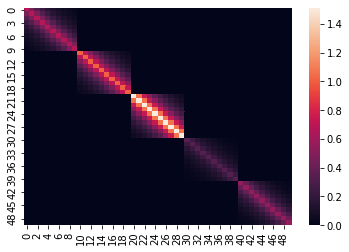

In [71]:
sns.heatmap(Sigma_sampling)

## Fitting the IMPS based model

In [37]:
batch_size = 20
IMPS_model = IMPS_PLN( nb_average_param = 15, nb_average_likelihood = 6)
%time IMPS_model.fit(Y,O,covariates, acc = 0.005,q = q, N_epoch_max = 160, class_optimizer = torch.optim.Adagrad, batch_size = batch_size, verbose = False, lr = 0.1, VR = 'SAGA',nb_plateau = 25)

device  cuda
Intialization ...
Initalization done


 85%|████████▌ | 136/160 [01:06<00:11,  2.04it/s]

Algorithm stopped after  136  iterations
CPU times: user 1min 6s, sys: 4.24 s, total: 1min 10s
Wall time: 1min 7s


In [87]:
fast = fastPLN()

fast.fit(Y, O, covariates, tol_delta = 0, tol_RMSE_M_grad = 0)

Initialization ...
nb iteration to find the mode:  90
Initialization finished
Maximum number of iterations reached :  200 last delta =  5.8611857436770984e-08


In [82]:
fast.beta-true_beta

tensor([[ 2.5061e-03,  2.4614e-02, -7.7875e-03,  5.3756e-02,  1.5374e-02,
         -4.1840e-02, -1.5174e-02, -2.9016e-02,  1.0996e-03, -7.9419e-04,
         -4.9631e-02,  8.4320e-04, -4.6759e-03,  9.2529e-03, -9.7480e-04,
          4.5179e-03, -1.6924e-02, -4.3389e-02, -2.5776e-02, -6.2416e-02,
          1.4138e-02,  3.9320e-02, -8.8308e-05,  5.1456e-02,  3.6132e-02,
          2.0620e-02, -2.9242e-03,  1.7333e-02, -4.5707e-03,  5.3623e-02,
          1.7285e-02,  1.1887e-02,  4.6910e-02, -1.4114e-03, -3.6785e-02,
         -3.8448e-03,  5.6672e-03,  1.6634e-02, -5.2893e-03, -5.0538e-02,
          2.2340e-03, -3.5742e-02,  3.5917e-02,  3.2770e-02, -1.6185e-02,
          1.5151e-02, -3.8947e-02, -7.0025e-02,  1.6099e-02,  9.3464e-03],
        [ 4.8504e-02, -4.8016e-03,  4.0008e-02,  3.8373e-02,  1.1370e-02,
          2.0217e-02, -9.2159e-03,  7.5990e-02,  5.3050e-02,  3.1628e-02,
          2.9741e-05, -2.6557e-02, -4.1646e-02, -1.2310e-02, -9.9361e-03,
          1.2336e-02,  3.1832e-02,  5

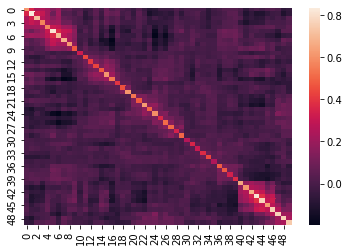

In [88]:
fast.show_Sigma()

In [89]:
torch.mean((fast.Sigma-true_Sigma)**2)

tensor(0.0080, device='cuda:0', grad_fn=<MeanBackward0>)

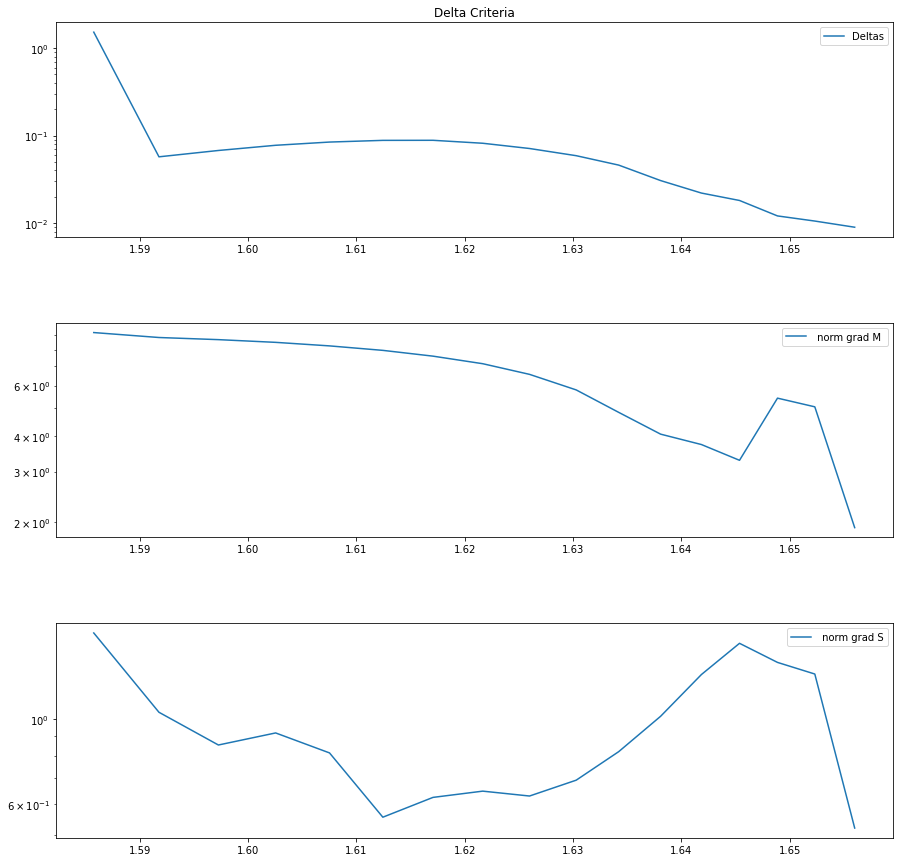

In [56]:
fast.show()

No handles with labels found to put in legend.
No handles with labels found to put in legend.


max likelihood : -1075.9443028401226


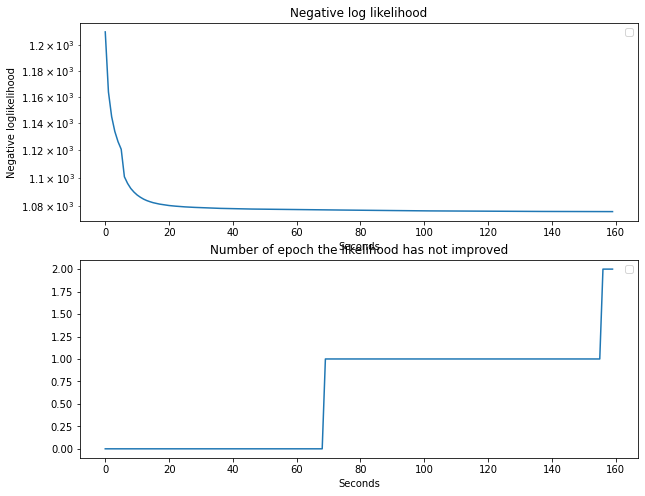

In [42]:
IMPS_model.show()

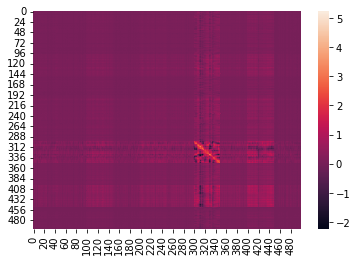

In [43]:
IMPS_model.show_Sigma()

<AxesSubplot:>

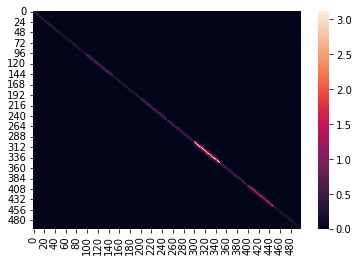

In [44]:
sns.heatmap(Sigma_sampling)

No handles with labels found to put in legend.
No handles with labels found to put in legend.


max likelihood : -129.95679254507417


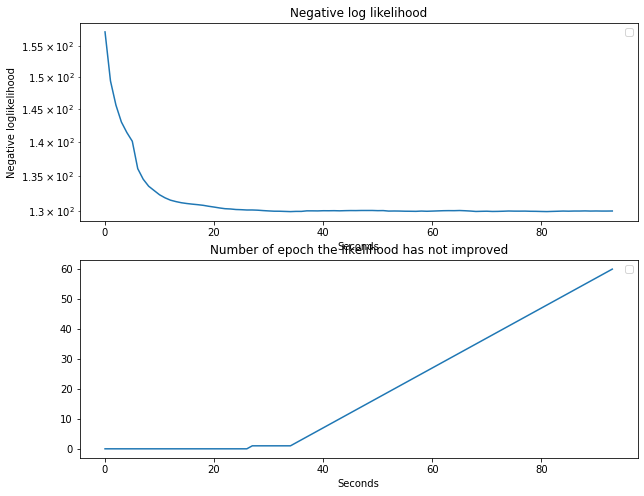

In [27]:
IMPS_model.show()

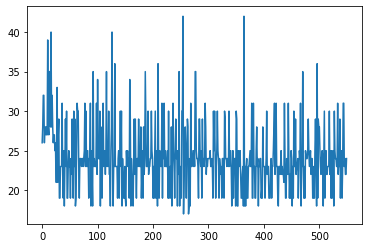

In [216]:
l = IMPS_model.nb_iteration_list

plt.plot(np.arange(0,len(l)), l)

In [217]:
np.mean(np.array(l))

24.12727272727273

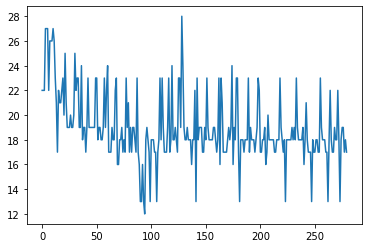

In [74]:
l = IMPS_model.nb_iteration_list

plt.plot(np.arange(0,len(l)), l)

<AxesSubplot:>

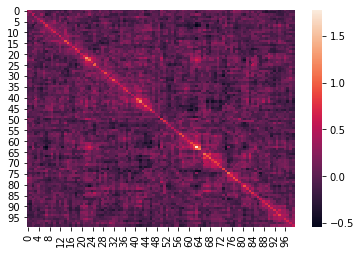

In [218]:
n_a = 0
n_b = 100
sns.heatmap(IMPS_model.Sigma()[n_a:n_b,n_a:n_b])

<AxesSubplot:>

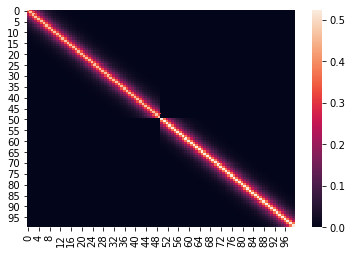

In [219]:
sns.heatmap(Sigma_sampling[n_a:n_b, n_a:n_b])

In [17]:
print('MSE beta', MSE(IMPS_model.beta_mean-true_beta))
print('MSE Sigma', MSE(IMPS_model.Sigma()-true_Sigma_sampling))

MSE beta tensor(0.0096)
MSE Sigma tensor(0.0160)


## fitting the Variational model

In [19]:
fastModel = fastPLN()
%time fastModel.fit(Y,O,covariates, 200, lr = 0.1, tolerance = 10e-4, verbose = True)
#fastModel.C = torch.from_numpy(C_from_Sigma(fastModel.Sigma.detach(), q)).detach()

device  cuda
beta device cuda:0
Iteration number:  0
-------UPDATE-------
Delta :  9.75402170827153
Iteration number:  10
-------UPDATE-------
Delta :  0.18955471169792176
Iteration number:  20
-------UPDATE-------
Delta :  0.041684391252357
Iteration number:  30
-------UPDATE-------
Delta :  0.008650699584322217
Iteration number:  40
-------UPDATE-------
Delta :  0.0020836944022131158
---------------------------------Tolerance 0.001 reached in 47 iterations
CPU times: user 358 ms, sys: 20.4 ms, total: 379 ms
Wall time: 374 ms


In [17]:
print(MSE(fastModel.Sigma-Sigma_sampling))
print(MSE(fastModel.beta-true_beta))

tensor(0.0148)
tensor(0.0098)


<AxesSubplot:>

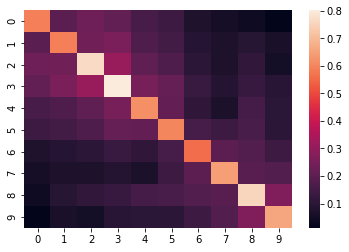

In [18]:
sns.heatmap(fastModel.Sigma.detach())

<AxesSubplot:>

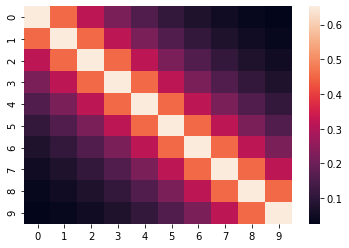

In [19]:
sns.heatmap(Sigma_sampling)

## Computing the likelihoods for each model.

In [18]:
log_like_IMPS_list = list()
log_like_fast_list = list()
for i in tqdm(range(20)): 
    log_like_IMPS_list.append(log_likelihood(Y,O,covariates, IMPS_model.C_mean, IMPS_model.beta_mean, acc = 0.005).detach().item())
    log_like_fast_list.append(log_likelihood(Y,O,covariates, fastModel.C, fastModel.beta.detach(), acc = 0.005).detach().item())

100%|██████████| 20/20 [00:12<00:00,  1.56it/s]


## Comparing both likelihoods 

/home/bastien/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/bastien/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


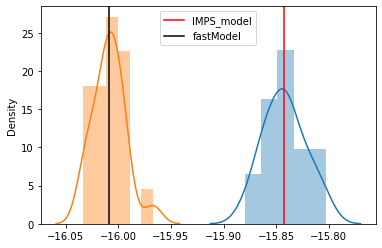

In [19]:
log_like_IMPS = np.mean(np.array(log_like_IMPS_list))
log_like_fast = np.mean(np.array(log_like_fast_list))


sns.distplot(np.array(log_like_IMPS_list))
plt.axvline(log_like_IMPS, label = 'IMPS_model', c = 'red')

sns.distplot(np.array(log_like_fast_list))
plt.axvline(log_like_fast, label = 'fastModel', c = 'black')
plt.legend()

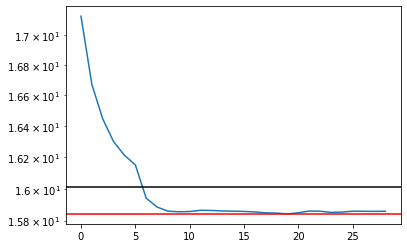

In [20]:
l = IMPS_model.log_likelihood_list
plt.plot(np.arange(0, len(l)), - np.array(l))

plt.axhline(-log_like_fast, c = 'black', label = 'IMPS_model')
plt.axhline(-log_like_IMPS, c = 'red', label = 'fastModel')
plt.yscale('log')

## Comparing the MSEs  

In [156]:
#print('MSE beta for IMPS', MSE(IMPS_model.beta_mean-true_beta))
print('MSE beta for Var App', MSE(fastModel.beta-true_beta).detach())

MSE beta for Var App tensor(0.0994)


In [157]:
#print('MSE Sigma for IMPS: ', MSE(IMPS_model.Sigma()-true_Sigma_sampling))
print('MSE Sigma for IMPS: ', MSE(fastModel.Sigma-true_Sigma_sampling))

MSE Sigma for IMPS:  tensor(0.7629, grad_fn=<MeanBackward0>)


## additional 

In [177]:
n = 30
X =  torch.arange(n,dtype = torch.float32, requires_grad = True) 



        
        
for batch, selected in get_batches(X): 
    print(selected)
    print(batch)

range(0, 10)
tensor([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.], dtype=torch.float32,
       grad_fn=<SliceBackward0>)
range(10, 20)
tensor([10., 11., 12., 13., 14., 15., 16., 17., 18., 19.], dtype=torch.float32,
       grad_fn=<SliceBackward0>)
range(20, 30)
tensor([20., 21., 22., 23., 24., 25., 26., 27., 28., 29.], dtype=torch.float32,
       grad_fn=<SliceBackward0>)


In [406]:
def loss(W): 
    return 1/2*torch.norm(W)**2
loss(X)

tensor(138.0450, dtype=torch.float32, grad_fn=<MulBackward0>)

In [411]:
def grad_ascent(selected_indices):
    batch = X[selected_indices]
    var_batch = batch.data
    var_batch.requires_grad_(True)
    new_optim = torch.optim.Rprop([var_batch], lr = 0.1)
    for j in range(3): 
        l = loss(var_batch)
        l.backward()
        var_batch.grad = d(var_batch)
        new_optim.step()
        new_optim.zero_grad()
    with torch.no_grad(): 
        X[selected_indices] = var_batch
        
def d(batch):
    return -batch

In [412]:
X =  torch.arange(10, dtype = torch.float32)
X.requires_grad_(True)
def get_batches(X): 
    indices = np.arange(30)
    #np.random.shuffle(indices)
    for i in range(3):
        print('indices', indices[i*10:(i+1)*10])
        yield (X[indices[i*10:(i+1)*10]], indices[i*10:(i+1)*10])

optim = torch.optim.Rprop([X], lr = 0.1)
res = []
for j in range(30): 
    for batch,selected_indices in get_batches(X):
        grad_ascent( selected_indices)
        print('batch :', batch)
    res.append(loss(X).item())
    print('-------------')
        
print('X :', X)
plt.plot(np.arange(len(res)), res)
plt.yscale('log')

indices [0 1 2 3 4 5 6 7 8 9]
batch : tensor([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.], dtype=torch.float32,
       grad_fn=<IndexBackward0>)
indices [10 11 12 13 14 15 16 17 18 19]


IndexError: index 10 is out of bounds for dimension 0 with size 10

X : tensor([ 0.0000e+00, -1.6228e-09, -1.0551e-06,  1.1596e-06,  4.2739e-07,
        -2.4585e-08, -8.3156e-07, -3.7272e-07, -1.0036e-06,  8.8013e-07],
       dtype=torch.float32, requires_grad=True)


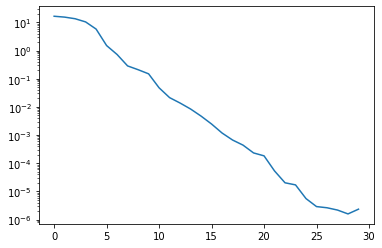

In [399]:
X =  torch.arange(10, dtype = torch.float32)
X.requires_grad_(True)
optim = torch.optim.Rprop([X], lr = 0.1)


res_bis = []
for j in range(90): 
    l = torch.norm(X)
    l.backward()
    optim.step()
    optim.zero_grad()
    if j%3 == 0 :
        res_bis.append(torch.norm(X).item())
    
print('X :', X)
plt.plot(np.arange(len(res_bis)), res_bis)
plt.yscale('log')

In [184]:
optim = torch.optim.Rprop([X], lr = 0.1)
for j in range(10): 
    for _, selected in get_batches(X):
        #W = X[selected].detach()
        l = loss(X)
        l.backward()
        optim.step()
        optim.zero_grad()
        print('batch', X[selected][-1])
    print('------------------')

batch tensor([0.1000, 0.1000], dtype=torch.float32, grad_fn=<SelectBackward0>)
batch tensor([0.1000, 0.1000], dtype=torch.float32, grad_fn=<SelectBackward0>)
batch tensor([0.0500, 0.0500], dtype=torch.float32, grad_fn=<SelectBackward0>)
------------------
batch tensor([-0.0100, -0.0100], dtype=torch.float32, grad_fn=<SelectBackward0>)
batch tensor([-0.0100, -0.0100], dtype=torch.float32, grad_fn=<SelectBackward0>)
batch tensor([0.0200, 0.0200], dtype=torch.float32, grad_fn=<SelectBackward0>)
------------------
batch tensor([0.0200, 0.0200], dtype=torch.float32, grad_fn=<SelectBackward0>)
batch tensor([0.0050, 0.0050], dtype=torch.float32, grad_fn=<SelectBackward0>)
batch tensor([-0.0130, -0.0130], dtype=torch.float32, grad_fn=<SelectBackward0>)
------------------
batch tensor([-0.0130, -0.0130], dtype=torch.float32, grad_fn=<SelectBackward0>)
batch tensor([-0.0040, -0.0040], dtype=torch.float32, grad_fn=<SelectBackward0>)
batch tensor([0.0068, 0.0068], dtype=torch.float32, grad_fn=<Sel

In [4]:
from fastPLNmodels.models import fastPLN
import pandas as pd
import torch

In [14]:
device = 'cuda'

In [15]:
Y = pd.read_csv('fastPLNmodels/Y_test')
O = pd.read_csv('fastPLNmodels/Y_test')
cov = pd.read_csv('fastPLNmodels/cov_test')
true_beta = torch.from_numpy(pd.read_csv('fastPLNmodels/true_beta_test').values).to(device)
true_Sigma = torch.from_numpy(pd.read_csv('fastPLNmodels/true_Sigma_test').values).to(device)





In [5]:
torch.from_numpy(Y.values)

tensor([[ 5.,  2.,  1.,  ...,  1.,  0.,  3.],
        [ 2., 14.,  1.,  ...,  3.,  0.,  0.],
        [ 3., 20.,  1.,  ...,  1.,  3.,  2.],
        ...,
        [ 1.,  0.,  1.,  ...,  7.,  5.,  0.],
        [ 0.,  0.,  8.,  ...,  1.,  0.,  0.],
        [ 1.,  0.,  4.,  ...,  2.,  4.,  0.]])

In [15]:
isinstance(Y, pd.DataFrame)


True

In [20]:
torch.is_tensor(torch.tensor([0]))

True

In [6]:
model = fastPLN()

In [9]:
model.fit(Y.values,O.values,cov.values)

Initialization ...
nb iteration to find the mode:  300
Initialization finished
Last delta: 3.5152142680902014, last_RMSE_M : 0.01590666298804358 reached in 115 iterations


In [17]:
torch.norm(model.beta-true_beta)

tensor(61.5202, device='cuda:0', grad_fn=<CopyBackwards>)